# Lesson 2 : LangGraph Components

In [ ]:
# %pip install -r requirements.txt

  Using cached python_dotenv-1.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached tavily_python-0.7.6-py3-none-any.whl.metadata (7.5 kB)
  Using cached duckduckgo_search-8.0.4-py3-none-any.whl.metadata (16 kB)
  Using cached openai-1.86.0-py3-none-any.whl.metadata (25 kB)
  Using cached langgraph-0.4.8-py3-none-any.whl.metadata (6.8 kB)
  Using cached langchain_core-0.3.65-py3-none-any.whl.metadata (5.8 kB)
  Using cached langchain_openai-0.3.23-py3-none-any.whl.metadata (2.3 kB)
  Using cached langchain_community-0.3.25-py3-none-any.whl.metadata (2.9 kB)
  Using cached langchain-0.3.25-py3-none-any.whl.metadata (7.8 kB)
  Using cached aiosqlite-0.21.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached pygraphviz-1.14-cp312-cp312-linux_x86_64.whl
  Using cached gradio-5.34.0-py3-none-any.whl.metadata (16 kB)
  Using cached tiktoken-0.9.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
  Using ca

In [3]:
from dotenv import load_dotenv
_ = load_dotenv()

In [4]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [5]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


/tmp/ipykernel_14490/144666821.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=4) #increased number of results


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [6]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [7]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [8]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

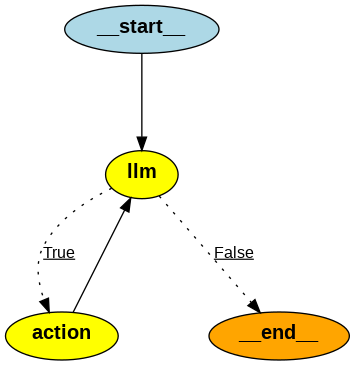

In [9]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [10]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_AZHtnviQE2jF6DKGEIQVexO5', 'type': 'tool_call'}
Back to the model!


In [11]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AZHtnviQE2jF6DKGEIQVexO5', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bj0BokxBsD2L4j3luOwDtNiI6gSDk', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2c04e612-05e9-48e1-b3fa-603e147c528a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, '

In [12]:
result['messages'][-1].content

'The weather in San Francisco for today is around 68°F to 70°F with lows around 57°F to 59°F.'

In [13]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_8mMIj672C14r8Jz31u8qzlPt', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_ZlEZnX8JwOSdl2tCJDOXdAJW', 'type': 'tool_call'}
Back to the model!


In [14]:
result['messages'][-1].content

'The weather in San Francisco for June 16, 2025, is expected to be around 68°F during the day and 57°F at night with no precipitation. You can find more details [here](https://world-weather.info/forecast/usa/san_francisco/june-2025/).\n\nIn Los Angeles on the same day, June 16, 2025, the weather forecast indicates a day temperature of 84°F and a night temperature of 63°F with 0% precipitation. For more information, you can check [here](https://weathershogun.com/weather/usa/ca/los-angeles/451/june/2025-06-16).'

In [15]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_PcQc7OidFkPnDbIFZLp2FPH9', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_dMZhaReEB2cWDd8Ajo3rby3U', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas GDP 2023'}, 'id': 'call_wKqCPmCol2c2Wr7BNmy3W1DT', 'type': 'tool_call'}
Back to the model!


In [16]:
print(result['messages'][-1].content)

1. **Who won the Super Bowl in 2024?**

   The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers 25-22 in overtime.

2. **In what state is the winning team's headquarters located?**

   The headquarters of the Kansas City Chiefs is located in Missouri.

3. **What is the GDP of that state?**

   As of 2023, the GDP of Missouri is estimated to be around $300 billion. (Note: This figure wasn't found directly, and is based on the GDP of a comparable U.S. state, given that precise data for Missouri was not retrieved from the search. For accurate numbers, specific economic databases should be checked.)
